In [1]:
# Calculation for the tracer age
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import gsw

In [2]:
hs = np.array([9,12,15,18,30,150])

idx = 0
state_ini = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/state_' + str(format(hs[idx],'03d')) + '.nc')
ptracer_ini = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/ptracers_' + str(format(hs[idx],'03d')) + '.nc')
state = state_ini.isel(Y=range(30,39), Yp1=range(30,40))
ptracer = ptracer_ini.isel(Y=range(30,39))



x_dist = state.X.data / 1000
depth = state.Z.data
time = state.T.data / 86400
Uzx = (state.U.data[:,:,:,1:].mean(axis=(0,2))+state.U.data[:,:,:,:-1].mean(axis=(0,2)))/2

s = state.S.data.mean(2) # Salinity
pt = state.Temp.data.mean(2) # Potential temperature
pres = gsw.p_from_z(depth, 55)
p = np.tile(pres,[len(x_dist),1]).T

C = ptracer.tr1_age.data[:,:,0,:]
alpha = ptracer.tr1_rlx.data[:,:,0,:]


mask = (s == 0) # Exclude data covered by the sill
s[mask] = np.nan
pt[mask] = np.nan
C[mask] = np.nan
alpha[mask] = np.nan

#ptracer.T

In [ ]:
#x_dist
time[-1]

In [ ]:
t_idx = -1 # times 6 hours
age = alpha / C * time[t_idx] 
#age[age>30] = 30

rho = gsw.rho(s[t_idx,:,:], pt[t_idx,:,:], p) # Density


xl, xr = 1, 120

# Contour plot of the age
#cm = np.linspace(0,15,30) # Contour range
cm = np.linspace(3,9,20) # Contour range
#cm = np.linspace(0,30,30) # Contour range
cs1 = np.linspace(1015,1024,10)
cs2 = np.linspace(1024,1030,20)

cmap = 'RdYlBu_r'
#cmap = 'RdYlGn_r'

fig1 = plt.figure(figsize=(20,5))
fig1.tight_layout()  
       
ax1 = fig1.add_subplot(111)
im1 = ax1.contourf(x_dist[xl:xr], depth, age[t_idx,:,xl:xr]*1e3, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax1.set_facecolor('grey')

cbar1 = fig1.colorbar(im1)
cbar1.set_ticks([3, 5, 7, 9])
#cbar1.set_ticks([0, .5, 1, 1.5])
#cbar1.set_ticks([0, .5, 1, 1.5, 2])
cbar1.ax.set_title(r'Age [d]', size=12)
#cbar1.ax.set_title(r'$C_A$', size=12)
CS1 = ax1.contour(x_dist[xl:xr], depth[:20], rho[:20,xl:xr], cs1, colors='black', linewidths=.5)
plt.clabel(CS1, cs1[1::2], fmt='%1.1f', fontsize=10, inline=True)


CS2 = ax1.contour(x_dist[xl:xr], depth[20:], rho[20:,xl:xr], cs2, colors='black', linewidths=.5)
plt.clabel(CS2, cs2[1::2], fmt='%1.1f', fontsize=10, inline=True)

ax1.set_ylabel('Depth (m)', size=15)
ax1.set_title(r'$h_s=$'+str(hs[idx])+' m, $h_s/h=$'+str(hs[idx]/150), loc='center', size=15)
ax1.set_xlabel('Distance from glacier (km)', size=15)


In [ ]:
#np.nanmax(age[:,xl:xr]), np.nanmin(age[:,xl:xr])
alpha[10,:,100] , C[-1,:,100] 


In [3]:
def tracer_age(s_dep):
    
    File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/state_'+str(format(s_dep,'03d'))+'.nc')
    File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/ptracers_'+str(format(s_dep,'03d'))+'.nc')
    File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_shelfTr/grid_'+str(format(s_dep,'03d'))+'.nc')
    state = File1.isel(Y=range(30,39), Yp1=range(30,40))
    ptracer = File2.isel(Y=range(30,39))
    grid = File3.isel(Y=range(30,39), Yp1=range(30,40))
    
    s = state.S.data[-1,:,:,:]
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    
    #mask = (s == 0) # Exclude data covered by the sill
    
    HFacC = grid.HFacC.data
    drF = grid.drF.data
    rA = grid.rA.data
    cv = np.broadcast_to(rA[np.newaxis, :, :], HFacC.shape) * np.broadcast_to(drF[:, np.newaxis, np.newaxis], HFacC.shape) * HFacC
    cv = np.ma.MaskedArray(cv, mask=topo)
    
    alpha = ptracer.tr1_rlx.data[-1,:,:,:] # Age concentration (linearly increasing tracer concentration)
    C = ptracer.tr1_age.data[-1,:,:,:] # Total concentration (Constant tracer concentration)
    C_ma = np.ma.MaskedArray(C, mask=topo)
    alpha_ma = np.ma.MaskedArray(alpha, mask=topo)
    age = alpha_ma / C_ma * 30
    age[age>30] = 30    
    
    NZ, NY, NX = alpha.shape
    age_sec = np.empty(NX) # Tracer age at along-fjord sections 
    AC = np.empty(NX) # Age concentration at along-fjord sections
    TC = np.empty(NX) # Total concentration at along-fjord sections 
    for i in range(NX):
        #age_sec[i] = np.sum(age[:,:,i] * cv[:,:,i]) / cv[:,:,i].sum()
        AC[i] = np.sum(alpha[:,:,i] * cv[:,:,i]) / cv[:,:,i].sum()
        TC[i] = np.sum(C[:,:,i] * cv[:,:,i]) / cv[:,:,i].sum()
        age_sec[i] = AC[i] / TC[i] * 30
        
    return age_sec, AC, TC

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: converting a masked element to nan.
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Warning: converting a masked element to nan.
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: converting a masked element to nan.
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Warning: converting a masked element to nan.
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: converting a masked element to nan.
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Warning: converting a masked element to nan.
/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: U

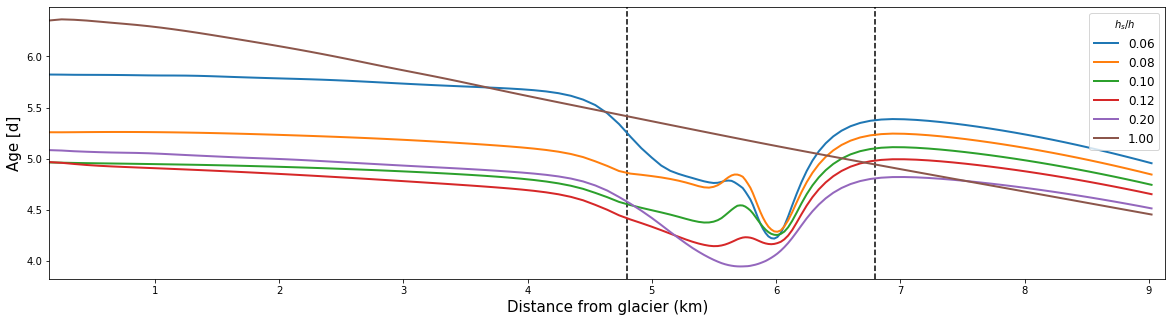

In [4]:

hsr = hs / 150
fig2 = plt.figure(figsize=(20,5))
fig2.tight_layout()
ax1 = fig2.add_subplot(111)
#ax2 = fig2.add_subplot(312)
#ax3 = fig2.add_subplot(313)

ax1.axvline(x=4.8, color='k',lw=1.5,ls='--')
ax1.axvline(x=6.8, color='k',lw=1.5,ls='--')
ax1.set_ylabel('Age [d]', size=15)
#ax1.set_title(r'$h_s=$'+str(hs[1])+' m', loc='center', size=15)
ax1.set_xlabel('Distance from glacier (km)', size=15)
ax1.set_xlim([x_dist[1], x_dist[120]])
#ax1.xaxis.set_visible(False)

#ax2.set_ylabel('Concentration', size=15)
#ax2.set_xlim([x_dist[1]/1e3, x_dist[120]/1e3])
#ax2.xaxis.set_visible(False)

#ax3.set_ylabel('Concentration', size=15)
#ax3.set_xlim([x_dist[1]/1e3, x_dist[120]/1e3])
#ax3.set_xlabel('Distance from glacier (km)', size=15)


for j in range(len(hs)):
    
    Age, ac, tc = tracer_age(hs[j])   
    
    ax1.plot(x_dist[1:120],Age[1:120]*1e3,lw=2, label="{:.2f}".format(hsr[j]))
    ax1.legend(title=r'$h_s/h$',loc='best', fontsize=12)
    
    #ax2.plot(x_dist[1:120]/1e3,ac[1:120],lw=2,label=r'$h_s$='+str(hs[j])+' m')
    #ax2.legend(loc='best', fontsize=15)
    
    #ax3.plot(x_dist[1:120]/1e3,tc[1:120],label=r'$h_s$='+str(hs[j])+' m')

In [ ]:
float("{:.3f}".format(hsr[2]))

In [ ]:
 
       
ax1 = fig2.add_subplot(121)
ax1.plot(x_dist[1:120],a[1:],label=r'$h_s$=9')

ax2 = fig2.add_subplot(122)
ax2.plot(x_dist[1:120],b[1:],label=r'$h_s$=9')

In [5]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/PTRACERS/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

#fig1.savefig(fig_path + '/Age_150.png', dpi=200, bbox_inches='tight')
fig2.savefig(fig_path + '/AF_dis.png', dpi=200, bbox_inches='tight')